# **Visual Transformer 2D**


In [67]:
import os
import sys
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.functional import kl_div
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

import open3d as o3
import math
import yaml
import argparse


np.random.seed(0)
torch.manual_seed(0)


sys.path.append('../')
from src.models.VisualTransformerEncoder import *
from src.models.VisualTransformerDecoder import *
from src.models.MultiHeadAttentionBlock import *
from src.models.VisualTransformerGenerator import *
from src.utils import features, utils
from src.data.dataset import DataMNIST, DataMNISTGen
from src.evaluation.evaluate import Evaluater
from src.utils.utils import *
from tqdm import tqdm, trange

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
print('MPS is build: {}'.format(torch.backends.mps.is_built()))
print('MPS Availability: {}'.format(torch.backends.mps.is_available()))
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device is set to :{}'.format(DEVICE))
torch.seed = 42

MPS is build: True
MPS Availability: True
Device is set to :mps


# DATA LOADING

In [4]:
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [5]:
data = DataMNISTGen(**config["data_parameters"])
data.setup()

Setting up training data...


60000it [00:20, 2904.84it/s]


Setting up validation data...


10000it [00:05, 1902.74it/s]


In [6]:
train_dataloader = data.train_dataloader()
val_dataloader = data.val_dataloader()

In [7]:
transformer = Transformer(config['model_parameters']['latent_dim'],
                          config['model_parameters']['num_heads'],
                          config['model_parameters']['num_layers'],
                          config['model_parameters']['d_ffn'],
                          config['trainer_parameters']['dropout'],
                          config['model_parameters']['n_patches']).to(config['model_parameters']['device'])

In [40]:
model_evaluate = Evaluater(
        model=transformer, 
        criterion=nn.MSELoss(),
        checkpoint='../models/checkpoints/Visual_Transformer/checkpoint_21.pth',
        experiment='VisualTransformer',
        device='mps',
        )

In [41]:
def TensorToImage(image):
    plt.figure(figsize = (2, 2))
    plt.imshow(image.numpy(), cmap='gray')
    return plt.show()

In [42]:
#images_ref, images_gen = next(iter(val_dataloader))
data = next(iter(val_dataloader))
images_ref, images_gen = data

In [64]:
#transformer.eval()
N=9
images, reconstructed_images = model_evaluate.evaluate_data(data)

Loss: 0.1083059310913086


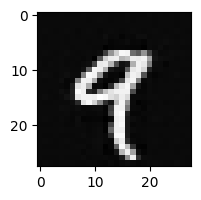

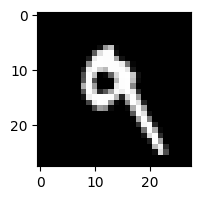

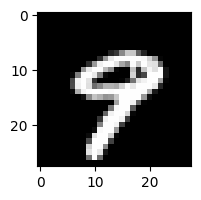

(None, None, None)

In [65]:
TensorToImage(reconstructed_images[N].squeeze().detach().cpu()), TensorToImage(images_gen[N].squeeze().detach().cpu()), TensorToImage(images_ref[N].squeeze().detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


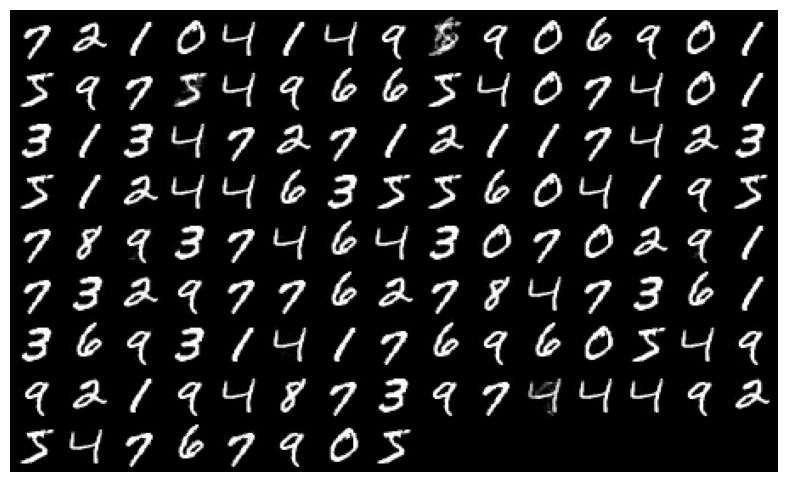

In [74]:
TensorToImageGrid(reconstructed_images.detach().cpu(), rows=6, cols=15)

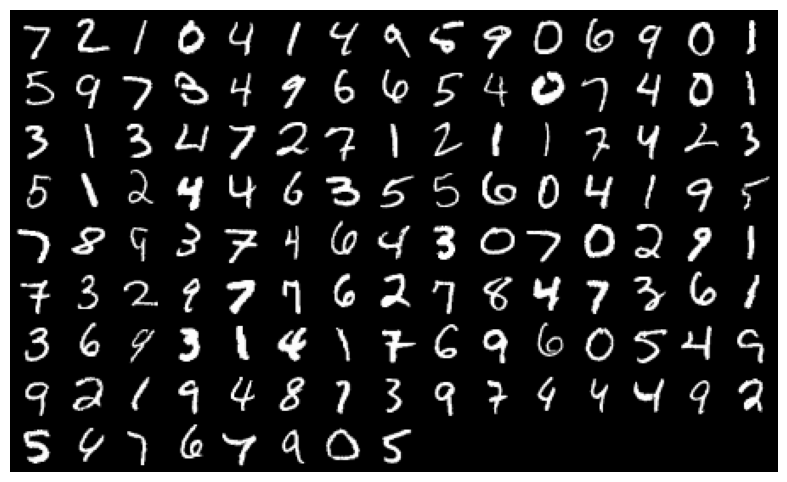

In [76]:
TensorToImageGrid(images_ref.detach().cpu(), rows=6, cols=15)

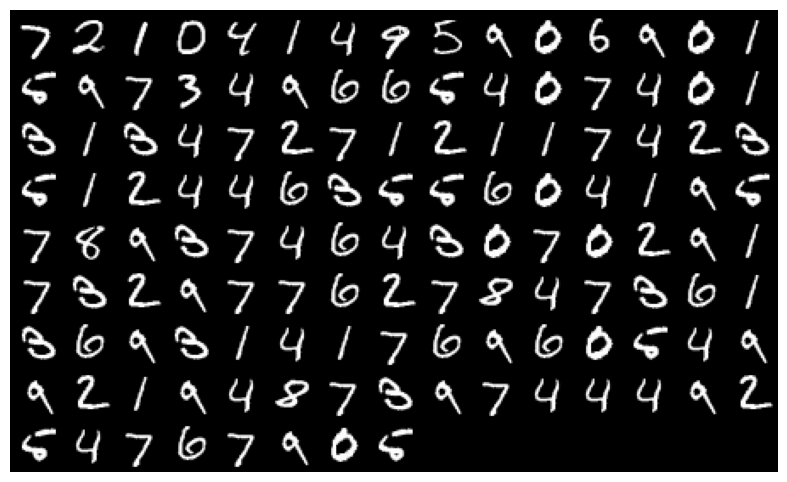

In [77]:
TensorToImageGrid(images_gen.detach().cpu(), rows=6, cols=15)

In [ ]:
TensorToImage(images[0].squeeze())